### **1.Importar librerías y definir rutas** ###

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import math

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10,5)

DATA_PATH = "../data/synthetic/synthetic_passwords.csv"


### **2.Cargar dataset** ###

In [2]:
df_syn = pd.read_csv(DATA_PATH)

print("Tamaño del dataset:", len(df_syn))
df_syn.head()


Tamaño del dataset: 4000000


,password
0,"75w\"",YEp#a]6i"
1,<s|sg%>xPxjlT
2,"Hn""V.[bhPc@JYib9V@l"
3,"ma,VWG`>#b3ze"
4,"h1m^^m&%""NOG7iB~zu"


Longitud de las contraseñas

Estadísticas de longitud:
count    4.000000e+06
mean     1.599821e+01
std      2.581647e+00
min      1.200000e+01
25%      1.400000e+01
50%      1.600000e+01
75%      1.800000e+01
max      2.000000e+01
Name: length, dtype: float64


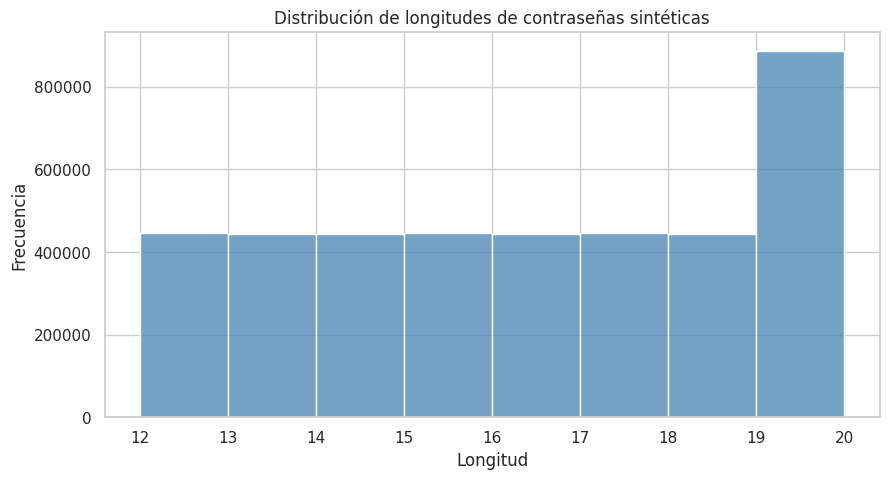

In [3]:
df_syn["length"] = df_syn["password"].astype(str).apply(len)

print("Estadísticas de longitud:")
print(df_syn["length"].describe())

sns.histplot(df_syn["length"], bins=range(df_syn["length"].min(), df_syn["length"].max()+1), color="steelblue")
plt.title("Distribución de longitudes de contraseñas sintéticas")
plt.xlabel("Longitud")
plt.ylabel("Frecuencia")
plt.show()


Cobertura de tipos de caracteres

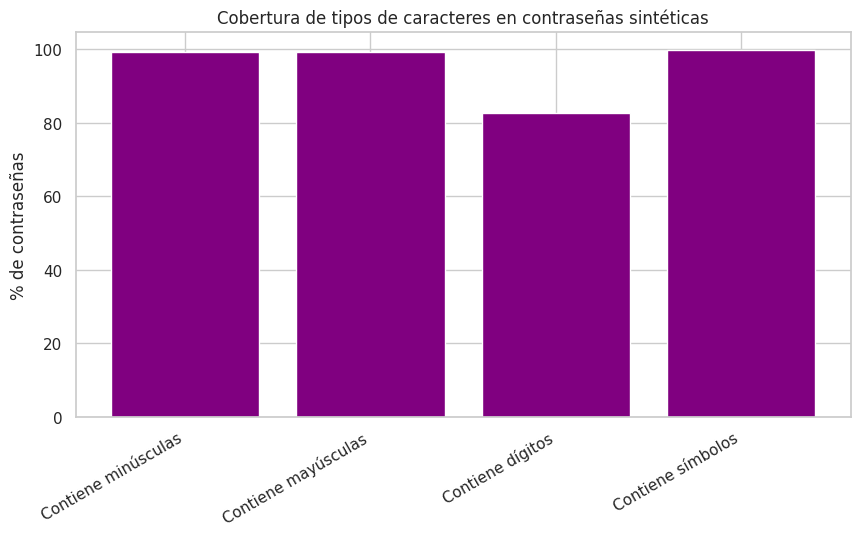

{'Contiene minúsculas': np.float64(0.99213225),
 'Contiene mayúsculas': np.float64(0.99217675),
 'Contiene dígitos': np.float64(0.82744925),
 'Contiene símbolos': np.float64(0.99783225)}

In [4]:
import string

df_syn["has_lower"]  = df_syn["password"].str.contains(r"[a-z]")
df_syn["has_upper"]  = df_syn["password"].str.contains(r"[A-Z]")
df_syn["has_digit"]  = df_syn["password"].str.contains(r"[0-9]")
df_syn["has_symbol"] = df_syn["password"].str.contains(r"[^A-Za-z0-9]")

coverage = {
    "Contiene minúsculas": df_syn["has_lower"].mean(),
    "Contiene mayúsculas": df_syn["has_upper"].mean(),
    "Contiene dígitos": df_syn["has_digit"].mean(),
    "Contiene símbolos": df_syn["has_symbol"].mean(),
}

plt.bar(coverage.keys(), [v*100 for v in coverage.values()], color="purple")
plt.ylabel("% de contraseñas")
plt.xticks(rotation=30, ha="right")
plt.title("Cobertura de tipos de caracteres en contraseñas sintéticas")
plt.show()

coverage


Distribución de caracteres

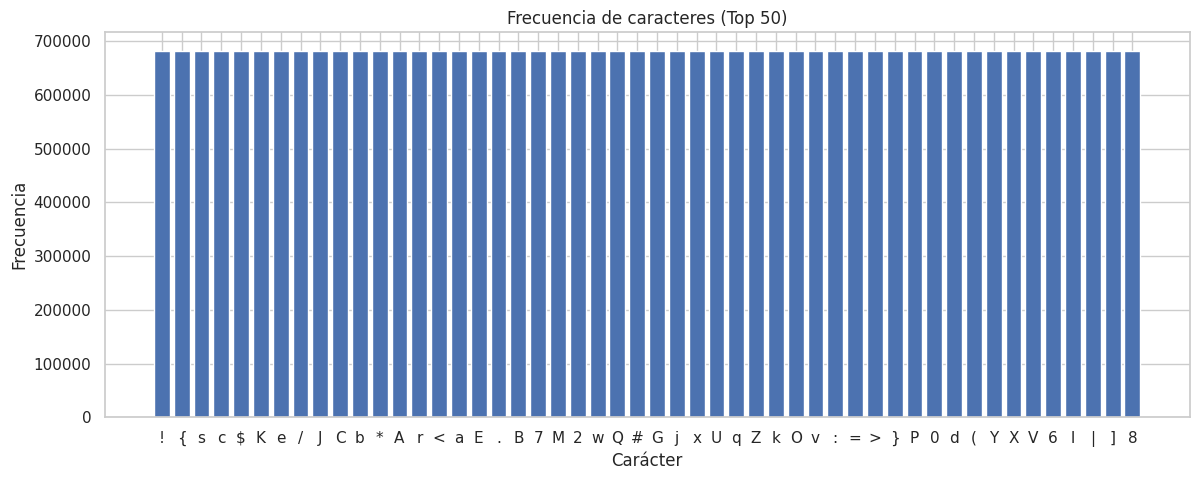

,char,count
61,!,682343
57,{,682279
15,s,682240
32,c,682023
60,$,682002
83,K,681885
42,e,681859
75,/,681847
34,J,681794
58,C,681763


In [5]:
# Extraer todos los caracteres en una sola serie
all_chars = "".join(df_syn["password"].astype(str).values)
char_counts = Counter(all_chars)

char_df = pd.DataFrame(char_counts.items(), columns=["char","count"]).sort_values("count", ascending=False)

plt.figure(figsize=(14,5))
plt.bar(char_df["char"].head(50), char_df["count"].head(50))
plt.title("Frecuencia de caracteres (Top 50)")
plt.xlabel("Carácter")
plt.ylabel("Frecuencia")
plt.show()

char_df.head(20)


Entropía

In [6]:
def entropy_shannon(pw: str) -> float:
    if not pw: return 0
    freq = Counter(pw)
    n = len(pw)
    return -sum((c/n) * math.log2(c/n) for c in freq.values())

def min_entropy(pw: str) -> float:
    if not pw: return 0
    freq = Counter(pw)
    n = len(pw)
    p_max = max(count/n for count in freq.values())
    return -math.log2(p_max)

def guessing_entropy(pw: str) -> float:
    H = entropy_shannon(pw)
    return 2**(H - 1) if H > 0 else 0

def combinatorial_entropy(pw: str) -> float:
    if not pw: return 0
    alphabet = set()
    for c in pw:
        if c.islower(): alphabet.add("lower")
        elif c.isupper(): alphabet.add("upper")
        elif c.isdigit(): alphabet.add("digit")
        else: alphabet.add("symbol")
    N = 0
    if "lower" in alphabet: N += 26
    if "upper" in alphabet: N += 26
    if "digit" in alphabet: N += 10
    if "symbol" in alphabet: N += 32
    m = len(pw)
    return m * math.log2(N) if N > 0 else 0


In [7]:
df_syn["entropy_shannon"] = df_syn["password"].astype(str).apply(entropy_shannon)
df_syn["entropy_min"] = df_syn["password"].astype(str).apply(min_entropy)
df_syn["entropy_guessing"] = df_syn["password"].astype(str).apply(guessing_entropy)
df_syn["entropy_combinatorial"] = df_syn["password"].astype(str).apply(combinatorial_entropy)

df_syn[["password","entropy_shannon","entropy_min","entropy_guessing","entropy_combinatorial"]].head()


,password,entropy_shannon,entropy_min,entropy_guessing,entropy_combinatorial
0,"75w\"",YEp#a]6i",3.807355,3.807355,7.000000,91.764244
1,<s|sg%>xPxjlT,3.392747,2.700440,5.251565,83.100126
2,"Hn""V.[bhPc@JYib9V@l",3.932138,3.247928,7.632407,124.537188
3,"ma,VWG`>#b3ze",3.700440,3.700440,6.500000,85.209655
4,"h1m^^m&%""NOG7iB~zu",3.947703,3.169925,7.715196,117.982599


In [8]:
print("Estadísticas de entropía:")
print(df_syn[["entropy_shannon","entropy_min","entropy_guessing","entropy_combinatorial"]].describe())

Estadísticas de entropía:
       entropy_shannon   entropy_min  entropy_guessing  entropy_combinatorial
count     4.000000e+06  4.000000e+06      4.000000e+06           4.000000e+06
mean      3.826023e+00  3.219294e+00      7.194863e+00           1.043114e+02
std       2.478219e-01  4.814320e-01      1.211655e+00           1.710399e+01
min       2.450826e+00  1.263034e+00      2.733645e+00           5.640528e+01
25%       3.640224e+00  2.906891e+00      6.234284e+00           9.176424e+01
50%       3.852169e+00  3.169925e+00      7.220850e+00           1.048734e+02
75%       4.021928e+00  3.584963e+00      8.122524e+00           1.179826e+02
max       4.321928e+00  4.321928e+00      1.000000e+01           1.310918e+02


Distribución de entropías

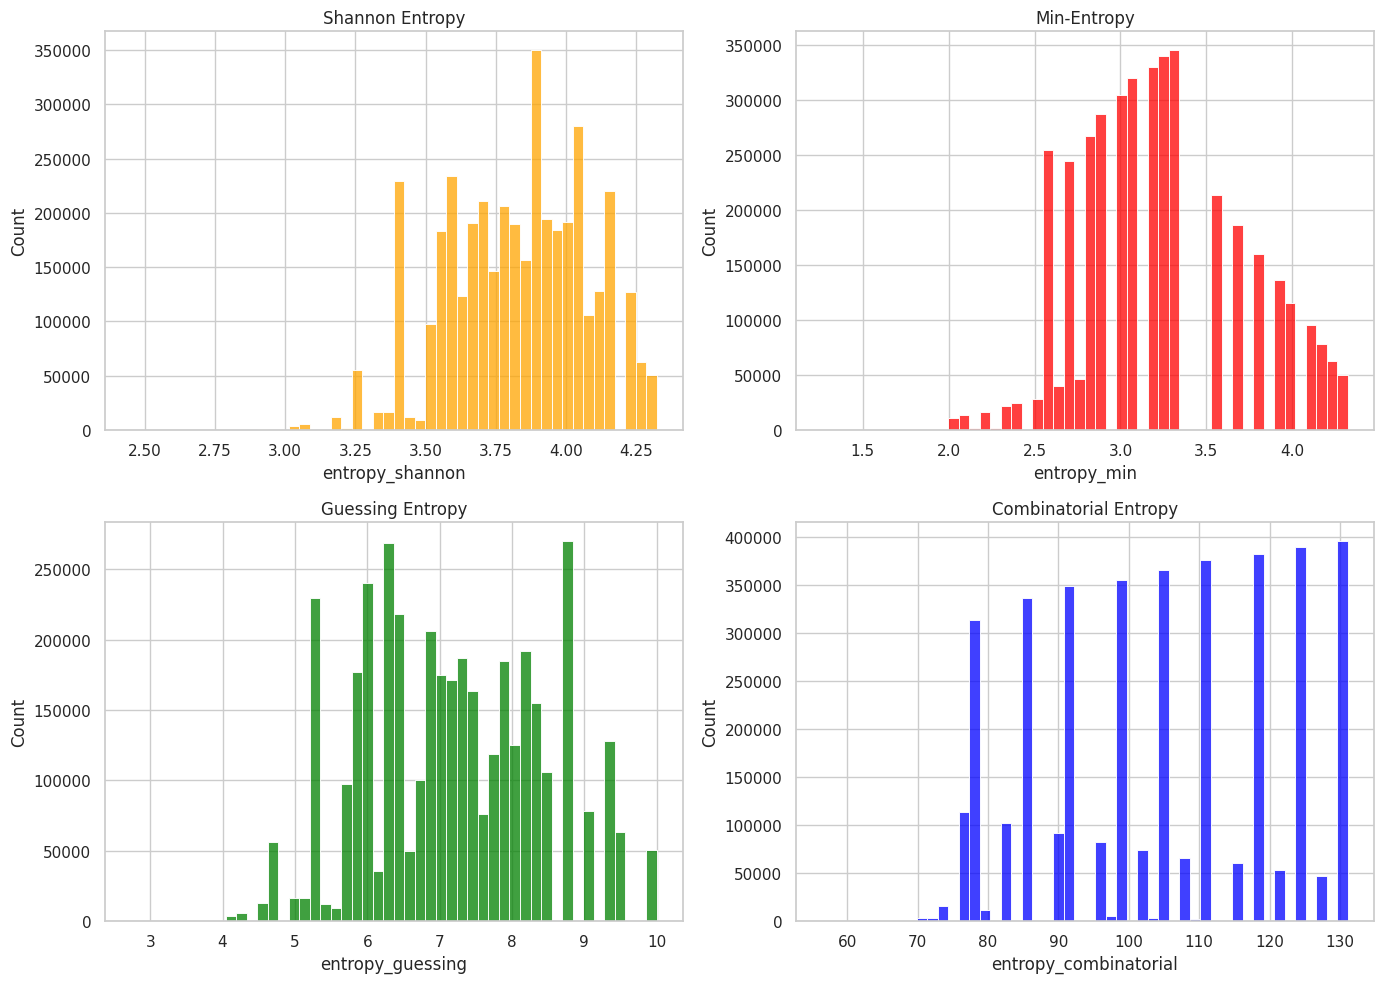

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(14,10))

sns.histplot(df_syn["entropy_shannon"], bins=50, ax=axes[0,0], color="orange")
axes[0,0].set_title("Shannon Entropy")

sns.histplot(df_syn["entropy_min"], bins=50, ax=axes[0,1], color="red")
axes[0,1].set_title("Min-Entropy")

sns.histplot(df_syn["entropy_guessing"], bins=50, ax=axes[1,0], color="green")
axes[1,0].set_title("Guessing Entropy")

sns.histplot(df_syn["entropy_combinatorial"], bins=50, ax=axes[1,1], color="blue")
axes[1,1].set_title("Combinatorial Entropy")

plt.tight_layout()
plt.show()


Longitud vs entropías

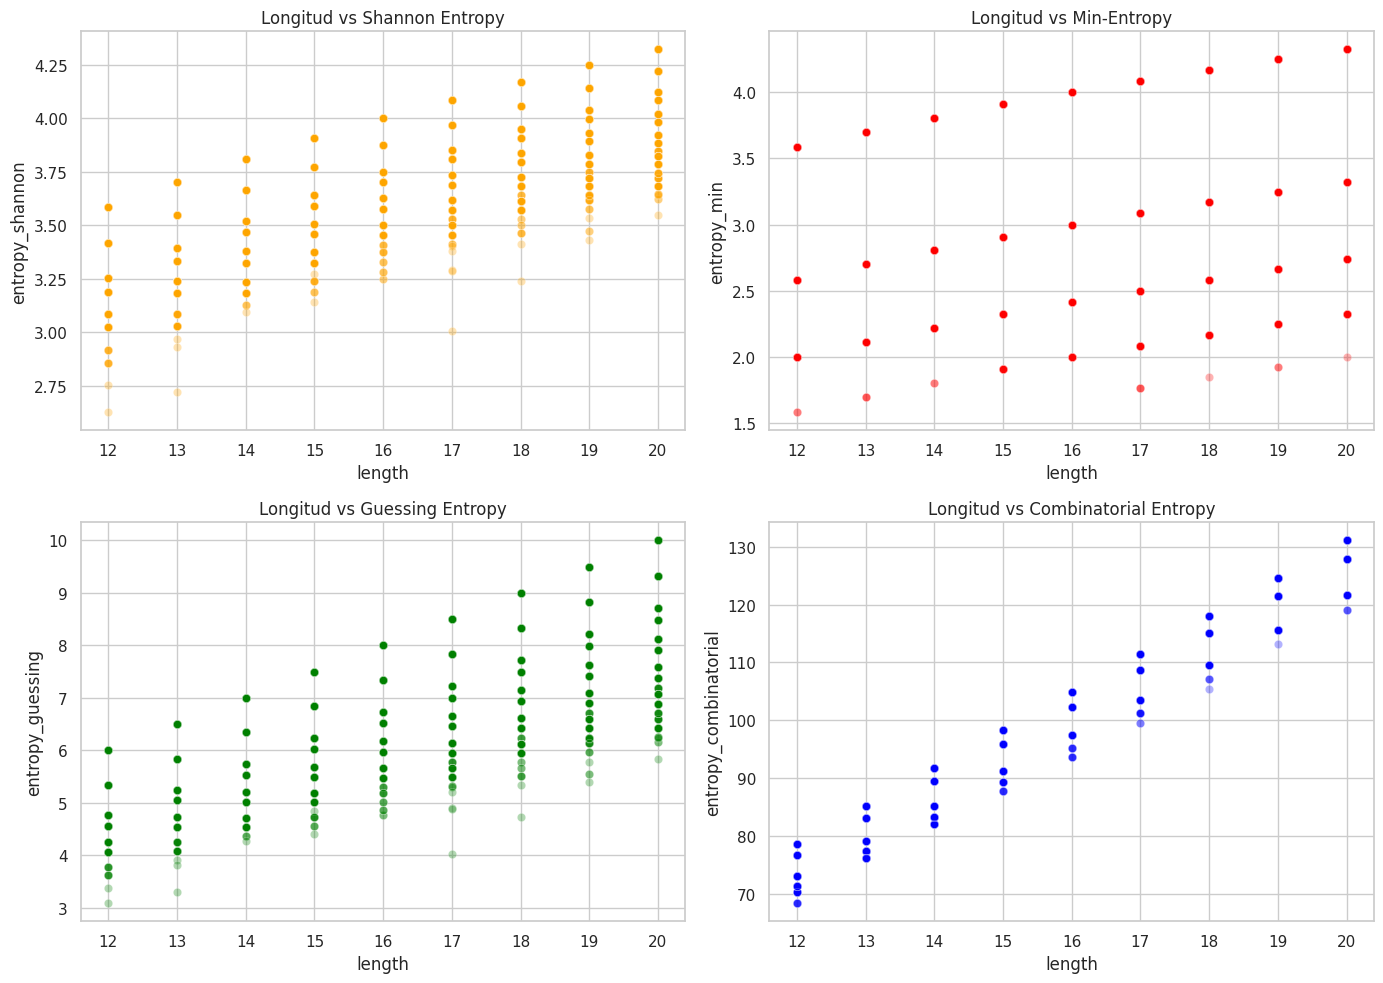

In [10]:
sample_df = df_syn.sample(min(50000, len(df_syn)), random_state=42)

fig, axes = plt.subplots(2, 2, figsize=(14,10))

sns.scatterplot(data=sample_df, x="length", y="entropy_shannon", alpha=0.3, ax=axes[0,0], color="orange")
axes[0,0].set_title("Longitud vs Shannon Entropy")

sns.scatterplot(data=sample_df, x="length", y="entropy_min", alpha=0.3, ax=axes[0,1], color="red")
axes[0,1].set_title("Longitud vs Min-Entropy")

sns.scatterplot(data=sample_df, x="length", y="entropy_guessing", alpha=0.3, ax=axes[1,0], color="green")
axes[1,0].set_title("Longitud vs Guessing Entropy")

sns.scatterplot(data=sample_df, x="length", y="entropy_combinatorial", alpha=0.3, ax=axes[1,1], color="blue")
axes[1,1].set_title("Longitud vs Combinatorial Entropy")

plt.tight_layout()
plt.show()


Duplicados y top contraseñas

In [11]:
duplicates = df_syn["password"].duplicated().sum()
print(f"Contraseñas duplicadas: {duplicates} ({duplicates/len(df_syn)*100:.5f}%)")

top10_syn = df_syn["password"].value_counts().head(10)
print("\n Top 10 contraseñas sintéticas más comunes:\n")
print(top10_syn)


Contraseñas duplicadas: 0 (0.00000%)

 Top 10 contraseñas sintéticas más comunes:

password
75w\",YEp#a]6i          1
<s|sg%>xPxjlT           1
Hn"V.[bhPc@JYib9V@l     1
ma,VWG`>#b3ze           1
h1m^^m&%"NOG7iB~zu      1
6+^Sz%6O*PXiF3?"\WEj    1
{C]sb+lQC$!5\486=       1
.cPOk[SU.~}egw,c[HB>    1
YCr)@H;+q0,M[A^3/D      1
*sgLdO,j%w3IP@          1
Name: count, dtype: int64


Bits/char

Entropía Shannon GLOBAL ≈ 6.555 bits/char


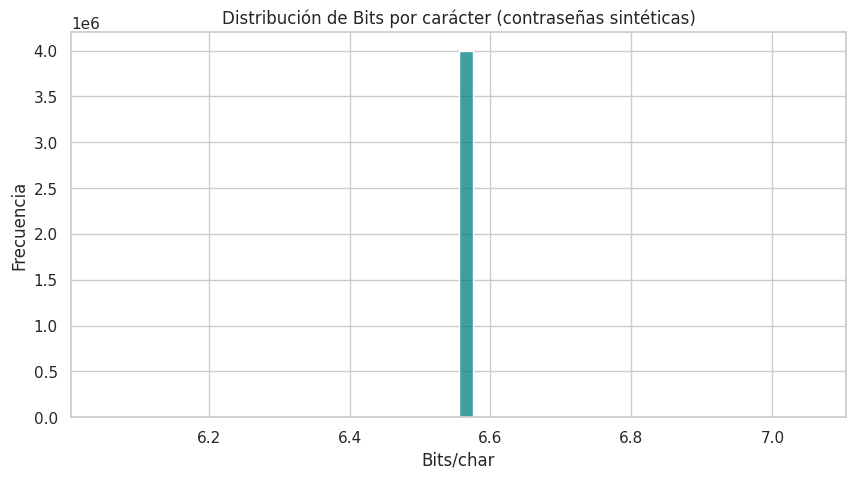

In [15]:
from collections import Counter
import math, string

alphabet = string.ascii_lowercase + string.ascii_uppercase + string.digits + string.punctuation
N = len(alphabet)

all_chars = "".join(df_syn["password"].astype(str).values)
freqs = Counter(all_chars)
total_chars = sum(freqs.values())

p = [cnt / total_chars for cnt in freqs.values() if cnt > 0]

H_global_bits_per_char = -sum(pi * math.log2(pi) for pi in p)
print(f"Entropía Shannon GLOBAL ≈ {H_global_bits_per_char:.3f} bits/char")

# Asignar el valor global a cada fila para graficar la distribución (todas las filas tendrán el mismo valor)
df_syn["H_global_bits_per_char"] = H_global_bits_per_char

sns.histplot(df_syn["H_global_bits_per_char"], bins=50, color="teal")
plt.title("Distribución de Bits por carácter (contraseñas sintéticas)")
plt.xlabel("Bits/char")
plt.ylabel("Frecuencia")
plt.show()


 Estadísticas de entropía combinatoria (bits):
count    4.000000e+06
mean     1.048617e+02
std      1.692163e+01
min      7.865507e+01
25%      9.176424e+01
50%      1.048734e+02
75%      1.179826e+02
max      1.310918e+02
Name: entropy_combinatorial, dtype: float64


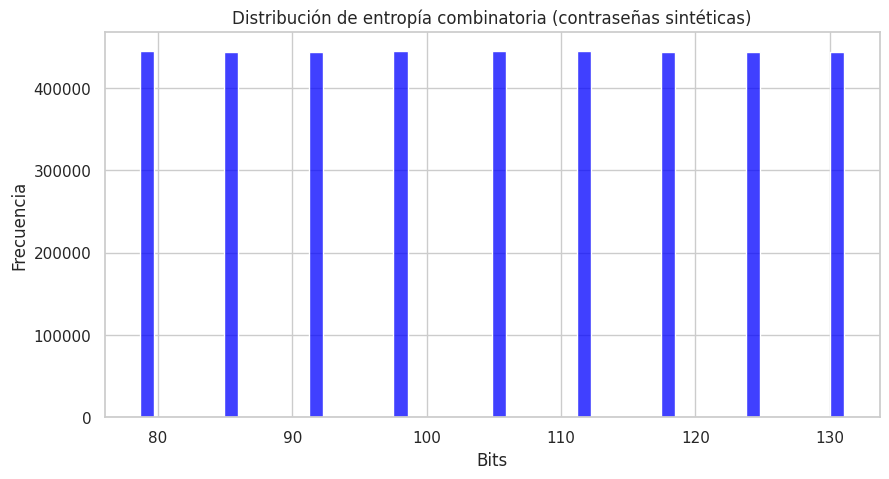

In [16]:
df_syn["entropy_combinatorial"] = df_syn["length"] * math.log2(N)

print(" Estadísticas de entropía combinatoria (bits):")
print(df_syn["entropy_combinatorial"].describe())

sns.histplot(df_syn["entropy_combinatorial"], bins=50, color="blue")
plt.title("Distribución de entropía combinatoria (contraseñas sintéticas)")
plt.xlabel("Bits")
plt.ylabel("Frecuencia")
plt.show()


KL-divergence

KL-divergence (P || U): 0.000001 bits


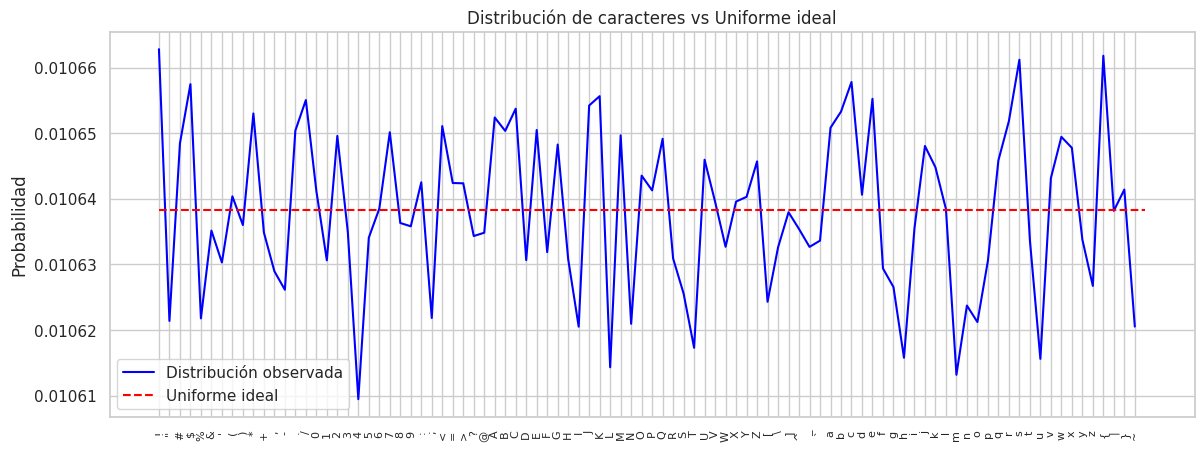

In [19]:
from collections import Counter
import string
import math

# Definir alfabeto usado en la generación (ASCII imprimibles comunes)
alphabet = string.ascii_lowercase + string.ascii_uppercase + string.digits + string.punctuation
N = len(alphabet)
uniform_prob = 1 / N

# Contar frecuencias de caracteres en TODAS las contraseñas
all_chars = "".join(df_syn["password"].astype(str).values)
freqs = Counter(all_chars)
total_chars = sum(freqs.values())

# Probabilidades observadas
P = {c: freqs.get(c, 0) / total_chars for c in alphabet}

# Calcular KL-divergence P || U
kl_div = sum(p * math.log2(p/uniform_prob) for c, p in P.items() if p > 0)

print(f"KL-divergence (P || U): {kl_div:.6f} bits")

# Visualización de diferencias
obs_probs = pd.Series(P).sort_index()
plt.figure(figsize=(14,5))
plt.plot(obs_probs.index, obs_probs.values, label="Distribución observada", color="blue")
plt.hlines(uniform_prob, xmin=0, xmax=len(obs_probs), colors="red", linestyles="dashed", label="Uniforme ideal")
plt.xticks(rotation=90, fontsize=8)
plt.ylabel("Probabilidad")
plt.title("Distribución de caracteres vs Uniforme ideal")
plt.legend()
plt.show()


 KL-divergence (P || U): 0.000001 bits (≈0 indica distribución uniforme)


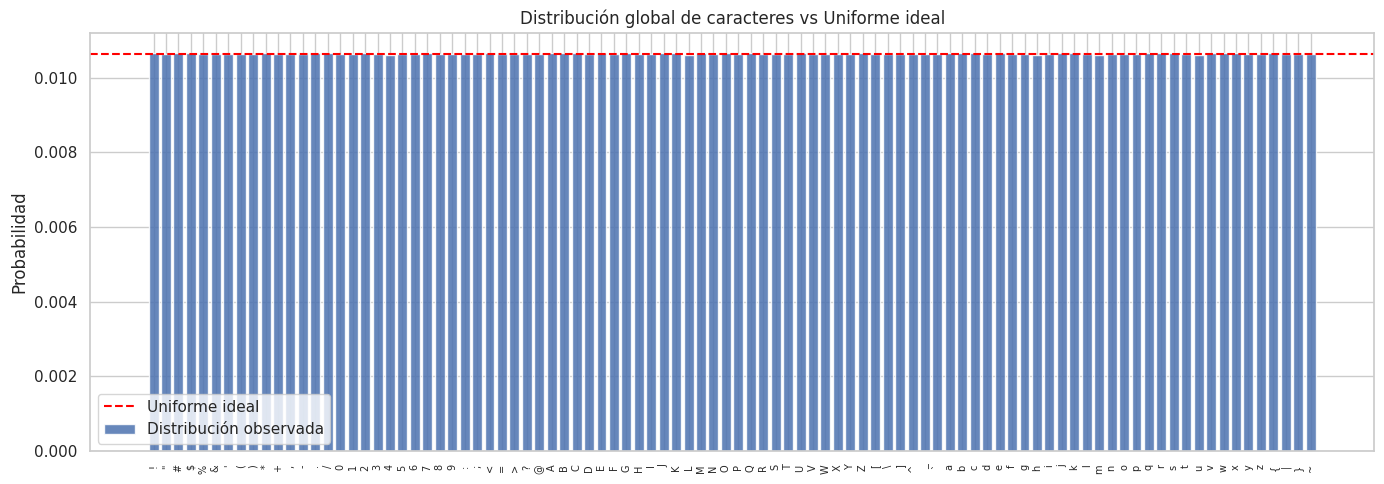

In [20]:
uniform_prob = 1 / N
KL_div = sum(pi * math.log2(pi / uniform_prob) for pi in p if pi > 0)
print(f" KL-divergence (P || U): {KL_div:.6f} bits (≈0 indica distribución uniforme)")

obs_probs = pd.Series({c: freqs.get(c, 0)/total_chars for c in alphabet}).sort_index()

plt.figure(figsize=(14,5))
plt.bar(obs_probs.index, obs_probs.values, label="Distribución observada", alpha=0.85)
plt.axhline(uniform_prob, color="red", linestyle="dashed", label="Uniforme ideal")
plt.xticks(rotation=90, fontsize=7)
plt.ylabel("Probabilidad")
plt.title("Distribución global de caracteres vs Uniforme ideal")
plt.legend()
plt.tight_layout()
plt.show()
